# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

In [1]:
# Your code here
import json
import requests
import pprint

def get_keys(path):
    with open(path) as f:
        return json.load(f)
    
keys = get_keys("/Users/indez/.secret/yelp_api.json")
api_key = keys["api_key"]

term = "Barbeque"
location = "Asheville NC"

url = "https://api.yelp.com/v3/businesses/search"

headers = {"Authorization": "Bearer {}".format(api_key)}

params = {
            "term" : term.replace(' ', '+'),
            "location" : location.replace(' ', '+'),
}

resp = requests.get(url, headers=headers, params=params)
pprint.pprint(resp.json())

{'businesses': [{'alias': '12-bones-smokehouse-river-asheville-2',
                 'categories': [{'alias': 'bbq', 'title': 'Barbeque'},
                                {'alias': 'smokehouse', 'title': 'Smokehouse'},
                                {'alias': 'sandwiches', 'title': 'Sandwiches'}],
                 'coordinates': {'latitude': 35.5775205,
                                 'longitude': -82.5660508},
                 'display_phone': '(828) 253-4499',
                 'distance': 1089.5348560091063,
                 'id': 'GZrNGIp1Kn7_Hp8duY04YQ',
                 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/PZwmTm1xo4zcHDuGLmN2mQ/o.jpg',
                 'is_closed': False,
                 'location': {'address1': '5 Foundy St',
                              'address2': '',
                              'address3': '',
                              'city': 'Asheville',
                              'country': 'US',
                              'display_address':

In [2]:
resp.json().keys()

dict_keys(['businesses', 'total', 'region'])

## Pagination

Now that you have an initial response, you can examine the contents of the JSON container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [3]:
# Your code here; use a function or loop to retrieve all the results from your original request
import pandas as pd
import numpy as np

def get_all_results(response):    
    total = response.json()['total']
    num_calls = np.floor(total/50) + 1
    
    total_list = []
    
    for i in range(int(num_calls)):
        offset = i * 50
        params = {
            "term" : term.replace(' ', '+'),
            "location" : location.replace(' ', '+'),
            "offset" : offset,
            "limit" : 50,
        }
        response = requests.get(url, headers=headers, params=params)
        
        total_list.append(response.json()['businesses'])
        
    flat_list = [item for sublist in total_list for item in sublist]
    df = pd.DataFrame(flat_list)
    
    return df
    

In [4]:
# Execute function to get the dataframe:
df = get_all_results(resp)

In [5]:
df.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,12-bones-smokehouse-river-asheville-2,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...","{'latitude': 35.5775205, 'longitude': -82.5660...",(828) 253-4499,1089.534856,GZrNGIp1Kn7_Hp8duY04YQ,https://s3-media3.fl.yelpcdn.com/bphoto/PZwmTm...,False,"{'address1': '5 Foundy St', 'address2': '', 'a...",12 Bones Smokehouse RIVER,+18282534499,$$,4.5,843,[delivery],https://www.yelp.com/biz/12-bones-smokehouse-r...
1,buxton-hall-barbecue-asheville,"[{'alias': 'southern', 'title': 'Southern'}, {...","{'latitude': 35.5892162495678, 'longitude': -8...",(828) 232-7216,726.000834,zypER_WyhdXTRKr39_-bLg,https://s3-media3.fl.yelpcdn.com/bphoto/NCsCla...,False,"{'address1': '32 Banks Ave', 'address2': None,...",Buxton Hall Barbecue,+18282327216,$$,4.0,829,[delivery],https://www.yelp.com/biz/buxton-hall-barbecue-...
2,luellas-bar-b-que-asheville-5,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...","{'latitude': 35.61527, 'longitude': -82.55462}",(828) 505-7427,3588.370819,VtIiHE74X8gEkXrJ4lRtUA,https://s3-media2.fl.yelpcdn.com/bphoto/iNbQF_...,False,"{'address1': '501 Merrimon Ave', 'address2': '...",Luella's Bar-B-Que,+18285057427,$$,4.5,514,[delivery],https://www.yelp.com/biz/luellas-bar-b-que-ash...
3,moes-original-bar-b-que-asheville,"[{'alias': 'soulfood', 'title': 'Soul Food'}, ...","{'latitude': 35.56585, 'longitude': -82.53815}",(828) 505-8282,2485.454352,RSEKsa3L4saGpGnr--EOqw,https://s3-media1.fl.yelpcdn.com/bphoto/29NjdR...,False,"{'address1': '4 Sweeten Creek Rd', 'address2':...",Moe's Original Bar B Que,+18285058282,$$,4.5,336,[],https://www.yelp.com/biz/moes-original-bar-b-q...
4,tiger-bay-asheville,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...","{'latitude': 35.57806, 'longitude': -82.57863}",(828) 713-3885,2115.495083,-xYVkP7rH4kEtfxwLxJUzQ,https://s3-media2.fl.yelpcdn.com/bphoto/oVLBvi...,False,"{'address1': '373 Haywood Rd', 'address2': '',...",Tiger Bay,+18287133885,$,4.5,47,[delivery],https://www.yelp.com/biz/tiger-bay-asheville?a...


In [6]:
# Check to make sure dataframe is expected length:
len(df)

258

## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [7]:
# First call info and describe function to see info and stats:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 16 columns):
alias            258 non-null object
categories       258 non-null object
coordinates      258 non-null object
display_phone    258 non-null object
distance         258 non-null float64
id               258 non-null object
image_url        258 non-null object
is_closed        258 non-null bool
location         258 non-null object
name             258 non-null object
phone            258 non-null object
price            241 non-null object
rating           258 non-null float64
review_count     258 non-null int64
transactions     258 non-null object
url              258 non-null object
dtypes: bool(1), float64(2), int64(1), object(12)
memory usage: 30.6+ KB
None


,distance,rating,review_count
count,258.000000,258.000000,258.000000
mean,5647.935378,3.748062,204.949612
std,4672.610897,0.779414,340.411186
min,454.306831,1.000000,1.000000
25%,2106.194430,3.500000,24.250000
50%,3571.318057,4.000000,83.500000
75%,8723.775320,4.500000,221.000000
max,18448.347372,5.000000,2636.000000


In [8]:
df.price.value_counts()

$$      132
$        99
$$$       8
$$$$      2
Name: price, dtype: int64

In [9]:
# Copying dataframe to preserve original
df2 = df.copy()

# Going to drop rows in duplicate dataframe to remove entries with NaN values for price
# This way price can be compared to other features accurately
df2 = df2[pd.notnull(df.price)]

#Now map lambda function

df2.price = df2.price.map(lambda x: len(x))
df2.price.head()

0    2
1    2
2    2
3    2
4    1
Name: price, dtype: int64

In [10]:
# Now another look at the info and describe:
print(df2.info())
df2.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 257
Data columns (total 16 columns):
alias            241 non-null object
categories       241 non-null object
coordinates      241 non-null object
display_phone    241 non-null object
distance         241 non-null float64
id               241 non-null object
image_url        241 non-null object
is_closed        241 non-null bool
location         241 non-null object
name             241 non-null object
phone            241 non-null object
price            241 non-null int64
rating           241 non-null float64
review_count     241 non-null int64
transactions     241 non-null object
url              241 non-null object
dtypes: bool(1), float64(2), int64(2), object(11)
memory usage: 30.4+ KB
None


,distance,price,rating,review_count
count,241.000000,241.000000,241.000000,241.000000
mean,5415.924825,1.639004,3.759336,218.850622
std,4591.611287,0.590174,0.737511,348.051664
min,454.306831,1.000000,1.000000,1.000000
25%,2033.963153,1.000000,3.500000,29.000000
50%,3390.968504,2.000000,4.000000,93.000000
75%,8432.518328,2.000000,4.500000,254.000000
max,18448.347372,4.000000,5.000000,2636.000000


C:\Users\indez\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


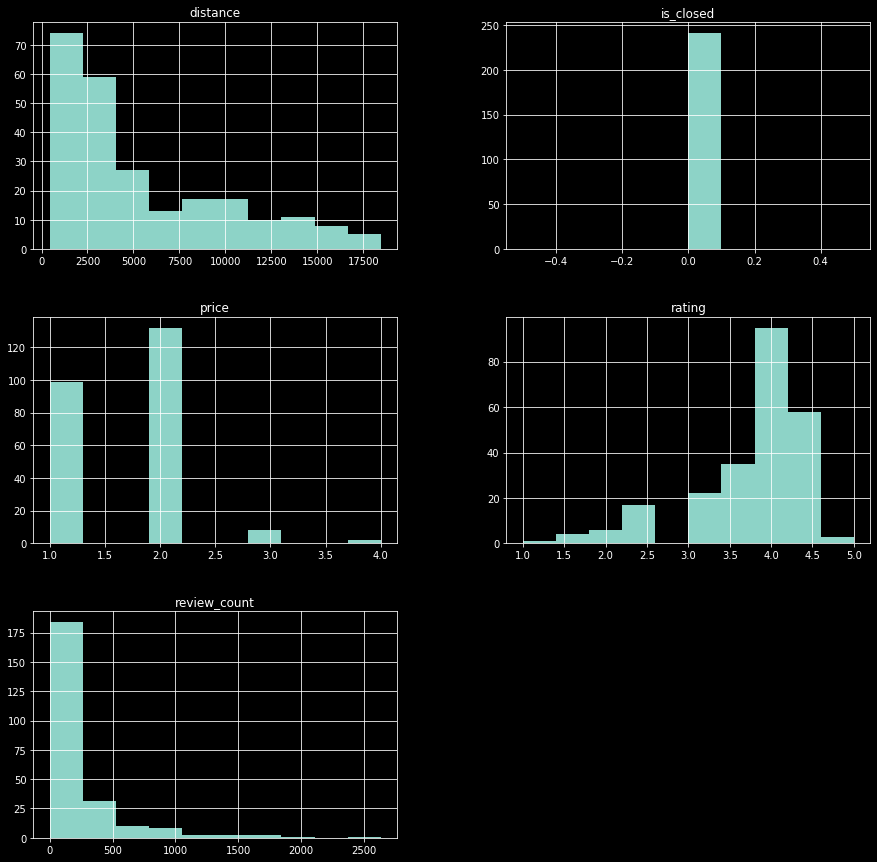

In [11]:
# A look at distributions:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

df2.hist(figsize=(15,15));

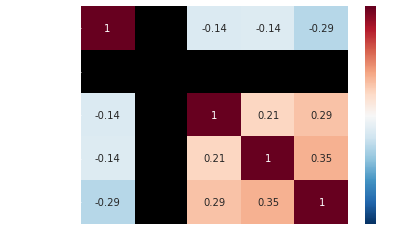

In [12]:
import seaborn as sns

# Using seaborn to produce heatmap and correlation scores:
corr = df2.corr()
heatmap = sns.heatmap(corr, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

Some mild correlations are shown. Distance from the center of the region has a negative correlation with the number of reviews, which would make sense since the most densely populated area would be in the downtown area, and therefore the most frequently visited barbeque restaurants. Distance also has a negative correlation with price and rating, which also makes sense since the price and quality of restaurants tend to decrease as one moves away from the city and into the countryside. Price, rating, and review count are positively correlated with one another.

Coefficients: [0.0006853]
Mean squared error: 0.53386178151571
Variance score: 0.08750588469455334


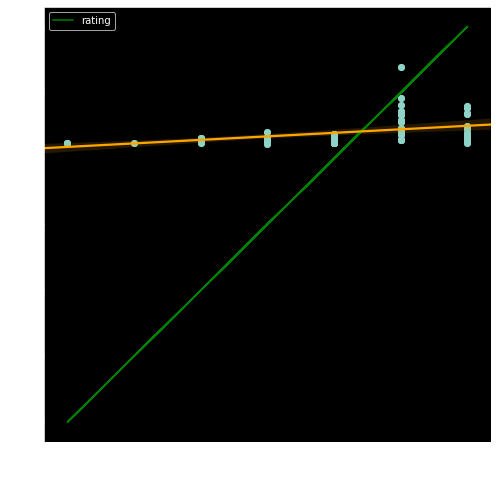

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Setting up X and y
X = pd.DataFrame(df2.review_count)
y = pd.DataFrame(df2.rating)

# Splitting data into training and testing sets and fitting model:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Making predictions on the test data
predicted = linreg.predict(X_test)

# The coefficients
print('Coefficients:', linreg.coef_.flatten())
# mean squared error
print("Mean squared error:", mean_squared_error(y_test, predicted))
# R Squared
print('Variance score:', r2_score(y_test, predicted))

# Make a plot of recorded vs predicted
fig = plt.figure(figsize=(8,8)) 
plt.scatter(y_test, predicted)
plt.plot(y_test, y_test, color='g', label='rating')
sns.regplot(x=y_test, y=predicted.flatten(), line_kws={'color':'orange'})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [15]:
# Your code here
import folium

center_lat = resp.json()['region']['center']['latitude']
center_long = resp.json()['region']['center']['longitude']

base_map = folium.Map([center_lat, center_long], zoom_start=13)

for index, row in df.iterrows():
    status = None
    
    lat = row['coordinates']['latitude']
    long = row['coordinates']['longitude']
    
    if row['is_closed']:
        status = 'closed'
    elif row['is_closed'] == False:
        status = 'open'
    
    popup_text = """Name: {},\n Rating: {},\n Price: {},\n
                    Phone: {},\n Currently {}""".format(row['name'],
                                                      row['rating'],
                                                      row['price'],
                                                      row['phone'],
                                                      status)
    
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup)
    marker.add_to(base_map)

base_map

## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!